Libraries
=

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import load_model


Data Loader
=

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = datagen.flow_from_directory(
    'D:/MO3 LAP/Datasets/Birds_525_Species/train',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='input'  #input means that the targets are images identical to input images
)

validation_generator = datagen.flow_from_directory(
    'D:/MO3 LAP/Datasets/Birds_525_Species/valid',
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='input'
)
test_generator = datagen.flow_from_directory(
    'D:/MO3 LAP/Datasets/Birds_525_Species/test'  ,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='input'
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


Define AutoEncoder
=

In [4]:
# Define convolutional block
def conv_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Define deconvolutional block
def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Define the encoder
def build_encoder(input_shape):
    inputs = Input(shape=input_shape)

    x = conv_block(inputs, 32, 3)
    x = conv_block(x, 64, 3)
    x = conv_block(x, 128, 3)
    x = conv_block(x, 256, 3)
    #x = conv_block(x, 512, 3)  # Additional layer
    #x = conv_block(x, 3, 3)  # Additional layer

    return Model(inputs, x, name='encoder')

# Define the decoder
def build_decoder(output_shape):
    inputs = Input(shape=output_shape)

    #x = deconv_block(inputs, 512, 3)  # Additional layer
    #x = deconv_block(inputs, 256, 3)  # Additional layer
    x = deconv_block(inputs, 128, 3)
    x = deconv_block(x, 64, 3)
    x = deconv_block(x, 32, 3)
    x = deconv_block(x, 3, 3)  # 3 channels for RGB images

    return Model(inputs, x, name='decoder')

# Define the autoencoder
def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(encoder.output_shape[1:])

    inputs = Input(shape=input_shape)

    encoded = encoder(inputs)
    decoded = decoder(encoded)

    autoencoder = Model(inputs, decoded, name='autoencoder')
    return encoder,decoder,autoencoder


Some parameters
=

In [5]:
num_train_images = 84635  
batch_size = 32
steps_per_epoch = num_train_images // batch_size

Train AutoEncoder
=

In [8]:
input_shape = (64, 64, 3)  
clean_encoder,clean_decoder,clean_autoencoder = build_autoencoder(input_shape)
clean_autoencoder.compile(optimizer=Adam(learning_rate=0.009), loss=MeanSquaredLogarithmicError(),metrics='accuracy')
clean_autoencoder.fit(train_generator, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=70)

Epoch 1/10
2644/2644 [==============================] - 87s 33ms/step - loss: 0.0074 - accuracy: 0.6388 - val_loss: 0.0046 - val_accuracy: 0.7977
Epoch 2/10
2644/2644 [==============================] - 40s 15ms/step - loss: 0.0043 - accuracy: 0.7698 - val_loss: 0.0046 - val_accuracy: 0.7605
Epoch 3/10
2644/2644 [==============================] - 40s 15ms/step - loss: 0.0037 - accuracy: 0.7828 - val_loss: 0.0033 - val_accuracy: 0.8129
Epoch 4/10
2644/2644 [==============================] - 40s 15ms/step - loss: 0.0034 - accuracy: 0.7956 - val_loss: 0.0034 - val_accuracy: 0.8167
Epoch 5/10
2644/2644 [==============================] - 39s 15ms/step - loss: 0.0031 - accuracy: 0.7986 - val_loss: 0.0033 - val_accuracy: 0.7911
Epoch 6/10
2644/2644 [==============================] - 39s 15ms/step - loss: 0.0029 - accuracy: 0.8032 - val_loss: 0.0028 - val_accuracy: 0.8106
Epoch 7/10
2644/2644 [==============================] - 40s 15ms/step - loss: 0.0027 - accuracy: 0.8064 - val_loss: 0.0025 -

Save AutoEncoder
=

In [9]:
clean_autoencoder.save('D:/MO3 LAP/GAN/assignment 3/models/clean_autoencoder.h5')  

AutoEncoder summary
=

In [10]:
clean_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 256)         390336    
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         389071    
                                                                 
Total params: 779,407
Trainable params: 777,993
Non-trainable params: 1,414
_________________________________________________________________


Load the AutoEncoder and get the Encoder and Decoder parts
=

In [6]:
autoencoder = load_model('D:/MO3 LAP/GAN/assignment 3/models/clean_autoencoder.h5')


encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')


Save Decoder 
=

In [18]:
decoder.save('D:/MO3 LAP/GAN/assignment 3/models/decoder.h5')  

Load Decoder
=

In [3]:
decoder = load_model('D:/MO3 LAP/GAN/assignment 3/models/decoder.h5')

Data Loaders
=

In [4]:
train_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/train'
test_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/test'  
val_dir = 'D:/MO3 LAP/Datasets/Birds_525_Species/valid'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=20, class_mode='input')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(64, 64), batch_size=20, class_mode='input')
validation_generator = validation_datagen.flow_from_directory(val_dir, target_size=(64, 64), batch_size=20, class_mode='input')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


Train Decoder on noised codes
=

In [ ]:
epochs = 15
noise_factor=0.5

for epoch in range(epochs):
    for i in range(len(train_generator)):
        
        batch_images = next(train_generator)[0]
        
        noisy_encoded_batch_images = encoder.predict(batch_images)
        
        noisy_encoded_batch_images += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=noisy_encoded_batch_images.shape)

        
        decoder.train_on_batch(noisy_encoded_batch_images, batch_images)

Save Decoder again
=

In [24]:
decoder.save('D:/MO3 LAP/GAN/assignment 3/models/decoder.h5')  

Test Decoder
=

In [8]:
noisy_images,original_images = next(test_generator)
encoded_images = encoder.predict(original_images)
encoded_images += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=noisy_encoded_batch_images.shape)
decoded_images = decoder.predict(encoded_images)

1/1 [==============================] - 0s 81ms/step


Plot results
=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


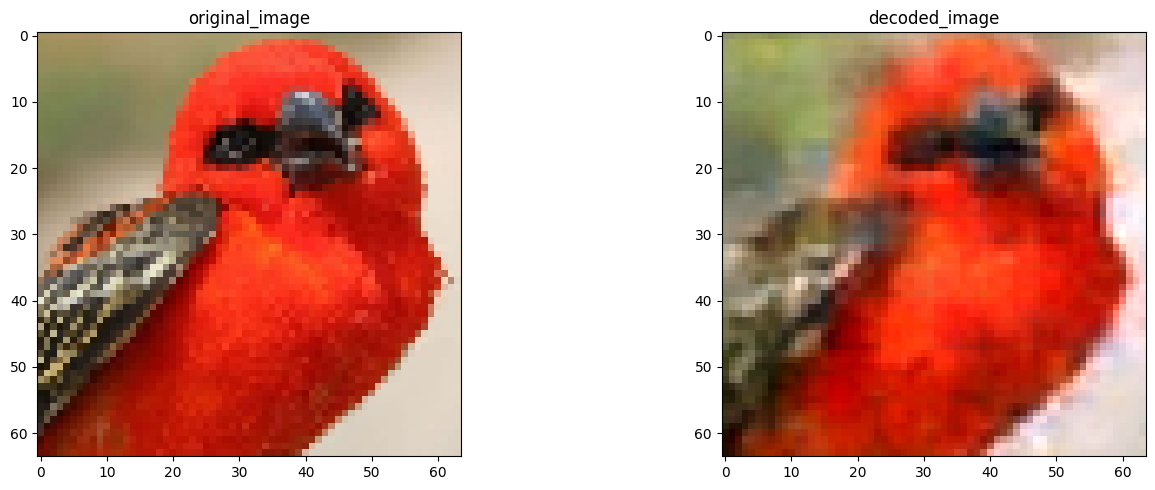

In [18]:

# Set the figure size
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed

# Plot the first image
plt.subplot(121)  # 1 row, 3 columns, first subplot
plt.imshow(original_images[9])
plt.title('original_image')

# Plot the second image
plt.subplot(122)  # 1 row, 3 columns, third subplot
plt.imshow(decoded_images[9])
plt.title('decoded_image')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


-----
Report
==
* I noticed that when adding noise to the input and let both **Encoder & Decoder** train to denoise is often better than noising the code and ask **only** the Decoder to densise and decode it 